# Imports

In [15]:
from queue import PriorityQueue
import string
import numpy as np
from operator import itemgetter
import random
import cv2
import matplotlib.pyplot as plt
import time

# Zad1 Algorytm znajdowania wzorca 2D

### Trie 

In [2]:
class Node:
    def __init__(self, char="", parent=None):
        self.char = char
        self.children = {}
        self.parent = parent
        self.val = None
        self.fail_link = None
        self.terminal = False

    def add_child(self, char):
        self.children[char] = Node(char, parent=self)

    def has_child(self, char):
        return char in self.children

    def get_child(self, char):
        return self.children.get(char)
    
    def get_parent(self):
        return self.parent
    
    def set_fail_link_to(self, other):
        self.fail_link = other
        
    def get_node_from_fail_link(self):
        return self.fail_link
    
    def has_fail_link(self):
        return self.fail_link is not None
    
    def set_terminal(self, val):
        self.output = val
        self.terminal = True
    
    def is_terminal(self):
        return self.terminal
    
    def get_terminal_val(self):
        return self.output

class Trie:
    def __init__(self, pattern_mapping):
        self.root = Node()
        self.insert(pattern_mapping)
    
    def insert(self, pattern_mapping):
        for pattern, mapping in pattern_mapping.items():
            node = self.root
            for c in pattern[:-1]:
                if not node.has_child(c):
                    node.add_child(c)
                node = node.get_child(c)

            if not node.has_child(pattern[-1]):
                node.add_child(pattern[-1])
            node = node.get_child(pattern[-1])
            node.set_terminal(mapping)

    def get_root(self):
        return self.root

### Aho Corasick Automaton

In [3]:
class Aho_Corasick_Automaton:
    def __init__(self, pattern_mapping):
        self.trie = Trie(pattern_mapping)
        self.create_fail_links()
    
    def create_fail_links(self):
        i = 0 # rank for priority queue
        queue = PriorityQueue()
        root = self.trie.get_root()
        
        for key, child in root.children.items():
            child.set_fail_link_to(root)
            queue.put((i, child))
            i += 1
        
        while not queue.empty():
            _, node = queue.get()
            for key, child in node.children.items():
                queue.put((i, child))
                i += 1
                x = node.get_node_from_fail_link()
                while not x.has_child(key):
                    if x.has_fail_link():
                        x = x.get_node_from_fail_link()
                    else:
                        break
                if not x.has_child(key) and not x.has_fail_link():
                    child.set_fail_link_to(x)
                else:
                    child.set_fail_link_to(x.get_child(key))
    
    # first loop
    def find_row_patterns(self, matrix):
        m , n = matrix.shape[:2]
        root = self.trie.get_root()
                
        res_matrix = np.zeros((m, n), dtype=np.int0)
        for i in range(m): # rows
            node = root
            row = matrix[i]
            for j in range(n): # columns
                c = row[j]
                while not node.has_child(c):
                    if node is not root:
                        node = node.get_node_from_fail_link()
                    else:
                        break
                if not node.has_fail_link() and not node.has_child(c):
                    continue
                node = node.get_child(c)
                
                if node.is_terminal():
                    res_matrix[i,j] = node.get_terminal_val()
        return res_matrix
    
    # second loop
    def find_col_patterns(self, matrix):
        m, n = matrix.shape[:2]
        root = self.trie.get_root()
        
        res = []
        for i in range(n): # columns
            node = root
            col = matrix[:, i]
            for j in range(m): # rows
                c = col[j]
                while not node.has_child(c):
                    if node is not root:
                        node = node.get_node_from_fail_link()
                    else:
                        break
                if node is root and not node.has_child(c):
                    continue
                node = node.get_child(c)

                if node.is_terminal():
                    val = node.get_terminal_val()
                    res.append((val, j, i)) # val , row and col idx
        return res

### Preprocessing text and patterns

In [4]:
def text_to_matrix(text):
    lines = text.splitlines(True) # keep linebreaks
    max_row_length = max(len(line) for line in lines) # number of columns
    
    lines = [line.ljust(max_row_length, "#") for line in lines] # padding
    matrix = np.array(list(map(list, lines)))
    return matrix

def patterns_mapping(patterns, img=False):
    single_pattern_mapping = dict()
    pattern_2d_mapping = dict()
    patterns_shapes = []
    
    single_mapping = 0
    mapping_sequence = 0
    for pattern_2d in patterns:
        pattern_2d_mapped_sequence = []
        patterns_shapes.append((len(pattern_2d), len(pattern_2d[0])))
        for pattern in pattern_2d:
            if img:
                pattern = tuple(pattern)
            if pattern not in single_pattern_mapping:
                single_mapping += 1
                single_pattern_mapping[pattern] = single_mapping
            pattern_2d_mapped_sequence.append(single_pattern_mapping[pattern])
        
        pattern_2d_mapped_sequence = tuple(pattern_2d_mapped_sequence)
        if pattern_2d_mapped_sequence not in pattern_2d_mapping:
            mapping_sequence += 1
            pattern_2d_mapping[pattern_2d_mapped_sequence] = mapping_sequence
    
    return patterns_shapes, single_pattern_mapping, pattern_2d_mapping

def get_alphabet(text):
    A = set()
    for c in text:
        if c in string.ascii_letters:
            A.add(c)
    return A

### Multiple 2d patterns matching algorithm

In [58]:
def find_2d_matches(text, patterns, img=False, timer=False):    
    patterns_shapes, single_pattern_mapping, pattern_2d_mapping = patterns_mapping(patterns, img)
    
    if img:
        matrix = text.copy()
    else:
        matrix = text_to_matrix(text) # np.array
    m , n = matrix.shape[:2]
    
    if timer:
        start = time.time()
    automata_rows = Aho_Corasick_Automaton(single_pattern_mapping)
    automata_cols = Aho_Corasick_Automaton(pattern_2d_mapping)
    if timer:
        building_time = time.time() - start
        print("Pattern size : {}".format(patterns_shapes))
        print("Automata building time : {}".format(building_time))
    
    
    if timer:
        start = time.time()
    matrix = automata_rows.find_row_patterns(matrix)
    occurences = automata_cols.find_col_patterns(matrix)
    if timer:
        matching_time = time.time() - start
        print("Pattern matching time : {}".format(matching_time))
        print()
    
    res = []
    for occurence in occurences:
        sequence_mapped_value, row_idx, col_idx = occurence
        pattern_n = sequence_mapped_value - 1
        m_pattern, n_pattern = patterns_shapes[pattern_n]
        
        # pattern , starting row and col idx
        if img:
            res.append((pattern_n, row_idx - m_pattern + 1, col_idx - n_pattern + 1)) # bcs its big pattern
        else:
            res.append((patterns[pattern_n], row_idx - m_pattern + 1, col_idx - n_pattern + 1))
        
    if timer:
        return building_time, matching_time
    else:
        return res

### Example of mapping

In [6]:
patterns = [["o", "e"], ["e", "o"]]
patterns_shapes, single_pattern_mapping, pattern_2d_mapping = patterns_mapping(patterns)
print(patterns_shapes)
print(single_pattern_mapping)
print(pattern_2d_mapping)

[(2, 1), (2, 1)]
{'o': 1, 'e': 2}
{(1, 2): 1, (2, 1): 2}


### File reading

In [7]:
with open("haystack.txt", "r") as f:
    text = f.read()

# Zad2

In [8]:
def find_all_letters_occurences(text):
    A = get_alphabet(text)
    patterns = []
    for letter in A:
        patterns.append([letter, letter])
    
    res = find_2d_matches(text, patterns)
    res = sorted(res, key=lambda x : x[0])
    return res

In [20]:
find_all_letters_occurences(text)

[(['a', 'a'], 64, 2),
 (['a', 'a'], 37, 4),
 (['a', 'a'], 20, 6),
 (['a', 'a'], 56, 11),
 (['a', 'a'], 52, 12),
 (['a', 'a'], 53, 12),
 (['a', 'a'], 64, 14),
 (['a', 'a'], 76, 21),
 (['a', 'a'], 64, 22),
 (['a', 'a'], 59, 24),
 (['a', 'a'], 3, 30),
 (['a', 'a'], 65, 35),
 (['a', 'a'], 69, 35),
 (['a', 'a'], 57, 36),
 (['a', 'a'], 58, 36),
 (['a', 'a'], 79, 37),
 (['a', 'a'], 77, 42),
 (['a', 'a'], 53, 48),
 (['a', 'a'], 31, 50),
 (['a', 'a'], 78, 59),
 (['a', 'a'], 5, 60),
 (['a', 'a'], 77, 61),
 (['a', 'a'], 6, 63),
 (['a', 'a'], 33, 66),
 (['a', 'a'], 28, 69),
 (['a', 'a'], 31, 73),
 (['a', 'a'], 76, 74),
 (['a', 'a'], 0, 82),
 (['c', 'c'], 41, 0),
 (['c', 'c'], 68, 0),
 (['c', 'c'], 13, 10),
 (['c', 'c'], 82, 41),
 (['c', 'c'], 10, 45),
 (['c', 'c'], 3, 54),
 (['d', 'd'], 37, 19),
 (['e', 'e'], 10, 1),
 (['e', 'e'], 14, 2),
 (['e', 'e'], 24, 3),
 (['e', 'e'], 17, 6),
 (['e', 'e'], 76, 6),
 (['e', 'e'], 77, 6),
 (['e', 'e'], 80, 6),
 (['e', 'e'], 1, 8),
 (['e', 'e'], 20, 10),
 (['e',

# Zad3

In [10]:
patterns = [["th", "th"], ["t h", "t h"]]
find_2d_matches(text, patterns)

[(['t h', 't h'], 37, 0)]

# Zad4

### Load all images

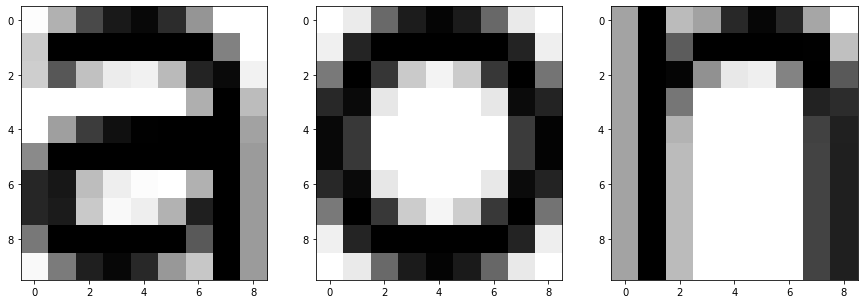

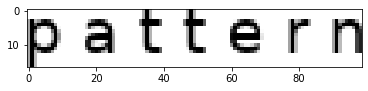

In [11]:
img = cv2.imread("haystack.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(1, 3, figsize=(15,15))
img_a = cv2.imread("a.png")
img_a = cv2.cvtColor(img_a, cv2.COLOR_BGR2GRAY)
ax[0].imshow(img_a, cmap="gray")

img_o = cv2.imread("o.png")
img_o = cv2.cvtColor(img_o, cv2.COLOR_BGR2GRAY)
ax[1].imshow(img_o, cmap="gray")

img_n = cv2.imread("n.png")
img_n = cv2.cvtColor(img_n, cv2.COLOR_BGR2GRAY)
ax[2].imshow(img_n, cmap="gray")
plt.show()

img_pattern = cv2.imread("pattern.png")
img_pattern = cv2.cvtColor(img_pattern, cv2.COLOR_BGR2GRAY)
plt.imshow(img_pattern, cmap="gray")
plt.show()

### Example of mapping img

In [12]:
patterns_mapping([img_o], img=True) # letter 'o' is not symmetric in 0-255

([(10, 9)],
 {(255, 235, 106, 28, 5, 27, 104, 234, 255): 1,
  (240, 37, 0, 0, 0, 0, 0, 35, 239): 2,
  (122, 0, 54, 202, 244, 203, 55, 0, 116): 3,
  (41, 10, 231, 255, 255, 255, 231, 11, 35): 4,
  (8, 56, 255, 255, 255, 255, 255, 59, 3): 5,
  (8, 57, 255, 255, 255, 255, 255, 59, 3): 6,
  (41, 10, 231, 255, 255, 255, 232, 11, 35): 7,
  (121, 0, 57, 204, 245, 205, 57, 0, 115): 8,
  (240, 37, 0, 0, 0, 0, 0, 35, 238): 9,
  (255, 234, 105, 27, 4, 26, 103, 233, 255): 10},
 {(1, 2, 3, 4, 5, 6, 7, 8, 9, 10): 1})

### 'a', 'o' and 'n' occurences

In [13]:
patterns = [img_a, img_o, img_n]
img_positions = find_2d_matches(img, patterns, img=True)
img_positions = sorted(img_positions, key=lambda x : x[0])
img_positions # 0 - img_a, 1 img_o , 2 img_n

[(0, 367, 26),
 (0, 411, 26),
 (0, 477, 26),
 (0, 565, 26),
 (0, 675, 26),
 (0, 1379, 26),
 (0, 1423, 26),
 (0, 1775, 26),
 (0, 1863, 26),
 (0, 785, 31),
 (0, 213, 32),
 (0, 1555, 36),
 (0, 301, 37),
 (0, 1049, 37),
 (0, 1643, 37),
 (0, 1841, 43),
 (0, 1005, 44),
 (0, 1313, 45),
 (0, 1445, 47),
 (0, 1335, 49),
 (0, 1181, 50),
 (0, 1467, 53),
 (0, 543, 55),
 (0, 103, 56),
 (0, 169, 56),
 (0, 653, 56),
 (0, 851, 56),
 (0, 873, 56),
 (0, 1687, 60),
 (0, 1533, 61),
 (0, 279, 63),
 (0, 1357, 64),
 (0, 521, 65),
 (0, 1445, 65),
 (0, 1797, 69),
 (0, 257, 72),
 (0, 1863, 72),
 (0, 785, 75),
 (0, 1775, 77),
 (0, 499, 78),
 (0, 1269, 78),
 (0, 1137, 80),
 (0, 1665, 80),
 (0, 477, 82),
 (0, 939, 83),
 (0, 191, 84),
 (0, 455, 84),
 (0, 323, 88),
 (0, 169, 90),
 (0, 675, 90),
 (0, 697, 93),
 (0, 1555, 93),
 (0, 257, 94),
 (0, 631, 97),
 (0, 345, 98),
 (0, 1093, 100),
 (0, 1511, 100),
 (0, 103, 105),
 (0, 125, 105),
 (0, 895, 106),
 (0, 1687, 107),
 (0, 1137, 110),
 (0, 807, 111),
 (0, 1643, 115),
 

# Zad5

### 'p a t t e r n' occurences

In [14]:
patterns = [img_pattern]
find_2d_matches(img, patterns, img=True)

[(0, 584, 142), (0, 474, 184), (0, 540, 242), (0, 628, 248), (0, 496, 428)]

# Zad6

### Patterns

In [93]:
# img_a 10x8
# img_pattern 17x99

size100 = cv2.imread("size100.png")
size100 = cv2.cvtColor(size100, cv2.COLOR_BGR2GRAY)

size200 = cv2.imread("size200.png")
size200 = cv2.cvtColor(size200, cv2.COLOR_BGR2GRAY)

size400 = cv2.imread("size400.png")
size400 = cv2.cvtColor(size400, cv2.COLOR_BGR2GRAY)

size800 = cv2.imread("size800.png")
size800 = cv2.cvtColor(size800, cv2.COLOR_BGR2GRAY)

In [94]:
def time_test(imgs, patterns):
    n_imgs = len(imgs)
    n_patterns = len(patterns)
    
    building_times = [0]*n_patterns
    matching_times = [0]*n_patterns
    
    for i in range(n_imgs):
        for j in range(n_patterns):
            res = find_2d_matches(imgs[i], patterns[j], img=True, timer=True)
            building_times[j] += res[0]
            matching_times[j] += res[1]
    return building_times, matching_times

### Times

In [95]:
all_patterns = [img_a, img_pattern, size100, size200, size400, size800]
patterns = [[img_a], [img_pattern], [size100], [size200], [size400], [size800], all_patterns]
res = time_test([img], patterns)
building_times = res[0]
matching_times = res[1]

Pattern size : [(10, 9)]
Automata building time : 0.0010018348693847656
Pattern matching time : 2.3642303943634033

Pattern size : [(17, 99)]
Automata building time : 0.009999275207519531
Pattern matching time : 2.440490484237671

Pattern size : [(100, 100)]
Automata building time : 0.0429990291595459
Pattern matching time : 2.514774799346924

Pattern size : [(200, 200)]
Automata building time : 0.18000125885009766
Pattern matching time : 2.4339022636413574

Pattern size : [(400, 400)]
Automata building time : 0.8229978084564209
Pattern matching time : 2.57515549659729

Pattern size : [(800, 800)]
Automata building time : 6.4292707443237305
Pattern matching time : 2.1990089416503906

Pattern size : [(10, 9), (17, 99), (100, 100), (200, 200), (400, 400), (800, 800)]
Automata building time : 6.758389711380005
Pattern matching time : 2.2682864665985107



### Plot times

Text(0, 0.5, 'Time [s]')

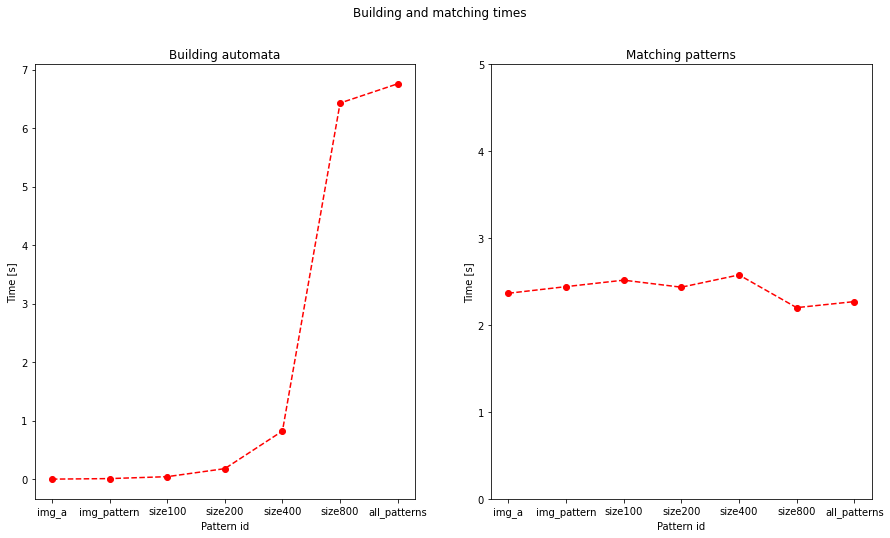

In [96]:
patterns_id = ["img_a", "img_pattern", "size100", "size200", "size400", "size800", "all_patterns"]

fig, ax = plt.subplots(1, 2, figsize=(15,8))
fig.suptitle("Building and matching times")
ax[0].plot(patterns_id, building_times, "r--o")
ax[0].set_title("Building automata")
ax[0].set_xlabel("Pattern id")
ax[0].set_ylabel("Time [s]")
ax[1].plot(patterns_id, matching_times, "r--o")
ax[1].set_ylim([0, 5])
ax[1].set_title("Matching patterns")
ax[1].set_xlabel("Pattern id")
ax[1].set_ylabel("Time [s]")

# Zad7

### 2, 4, 8 fragments

In [ ]:
Dla każdego fragmentu automat jest budowany od nowa ale nie ma to znaczenia dla czasów przeszukiwania.

In [97]:
img.shape

(1900, 860)

In [98]:
img_2 = [img[i*img.shape[0]//2:(i+1)*img.shape[0]//2, :] for i in range(2)]
print(img_2[0].shape, img_2[1].shape)
img_4 = [img[i*img.shape[0]//4:(i+1)*img.shape[0]//4, :] for i in range(4)]
print(img_4[0].shape, img_4[1].shape, img_4[2].shape, img_4[3].shape)
img_8 = [img[i*img.shape[0]//8:(i+1)*img.shape[0]//8, :] for i in range(8)]
print(img_8[0].shape, img_8[1].shape, img_8[2].shape, img_8[3].shape,
      img_8[4].shape, img_8[5].shape, img_8[6].shape, img_8[7].shape)

(950, 860) (950, 860)
(475, 860) (475, 860) (475, 860) (475, 860)
(237, 860) (238, 860) (237, 860) (238, 860) (237, 860) (238, 860) (237, 860) (238, 860)


### Img 2 fragments

In [99]:
all_patterns = [img_a, img_pattern, size100, size200, size400, size800]
patterns = [[img_a], [img_pattern], [size100], [size200], [size400], [size800], all_patterns]
res = time_test(img_2, patterns)
building_times = res[0]
matching_times = res[1]

Pattern size : [(10, 9)]
Automata building time : 0.0012252330780029297
Pattern matching time : 1.3282525539398193

Pattern size : [(17, 99)]
Automata building time : 0.00896763801574707
Pattern matching time : 1.1780564785003662

Pattern size : [(100, 100)]
Automata building time : 0.04705333709716797
Pattern matching time : 1.2867436408996582

Pattern size : [(200, 200)]
Automata building time : 0.2090623378753662
Pattern matching time : 1.2780427932739258

Pattern size : [(400, 400)]
Automata building time : 1.6142349243164062
Pattern matching time : 1.3548712730407715

Pattern size : [(800, 800)]
Automata building time : 4.921627521514893
Pattern matching time : 1.183304786682129

Pattern size : [(10, 9), (17, 99), (100, 100), (200, 200), (400, 400), (800, 800)]
Automata building time : 6.599594831466675
Pattern matching time : 1.2499055862426758

Pattern size : [(10, 9)]
Automata building time : 0.0010001659393310547
Pattern matching time : 1.3058969974517822

Pattern size : [(17,

Text(0, 0.5, 'Time [s]')

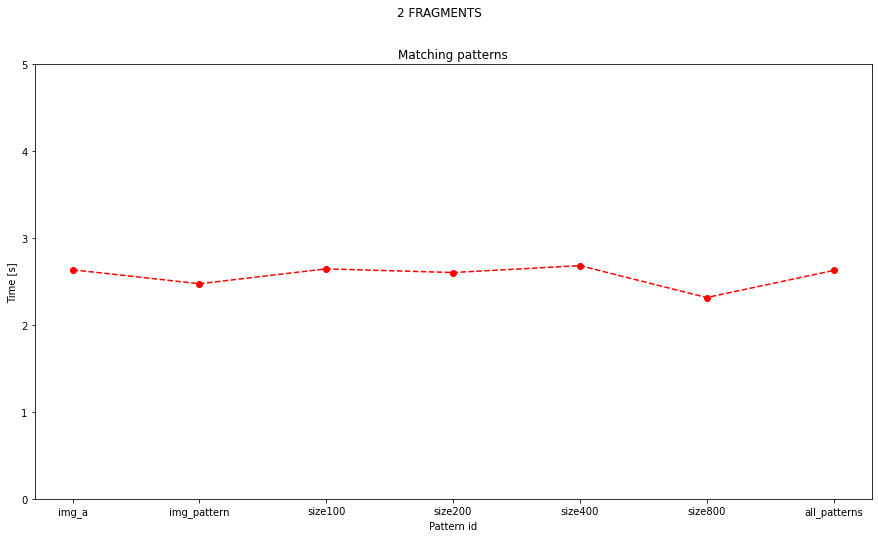

In [101]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
fig.suptitle("2 FRAGMENTS")
ax.plot(patterns_id, matching_times, "r--o")
ax.set_ylim([0, 5])
ax.set_title("Matching patterns")
ax.set_xlabel("Pattern id")
ax.set_ylabel("Time [s]")

### Img 4 fragments

In [102]:
all_patterns = [img_a, img_pattern, size100, size200, size400, size800]
patterns = [[img_a], [img_pattern], [size100], [size200], [size400], [size800], all_patterns]
res = time_test(img_4, patterns)
building_times = res[0]
matching_times = res[1]

Pattern size : [(10, 9)]
Automata building time : 0.0017347335815429688
Pattern matching time : 0.5956242084503174

Pattern size : [(17, 99)]
Automata building time : 0.008032798767089844
Pattern matching time : 0.637005090713501

Pattern size : [(100, 100)]
Automata building time : 0.03999781608581543
Pattern matching time : 0.6484918594360352

Pattern size : [(200, 200)]
Automata building time : 0.18562102317810059
Pattern matching time : 0.6090335845947266

Pattern size : [(400, 400)]
Automata building time : 1.4746403694152832
Pattern matching time : 0.6730272769927979

Pattern size : [(800, 800)]
Automata building time : 6.961668014526367
Pattern matching time : 0.6550328731536865

Pattern size : [(10, 9), (17, 99), (100, 100), (200, 200), (400, 400), (800, 800)]
Automata building time : 7.163971185684204
Pattern matching time : 0.6050000190734863

Pattern size : [(10, 9)]
Automata building time : 0.0010018348693847656
Pattern matching time : 0.6634814739227295

Pattern size : [(1

Text(0, 0.5, 'Time [s]')

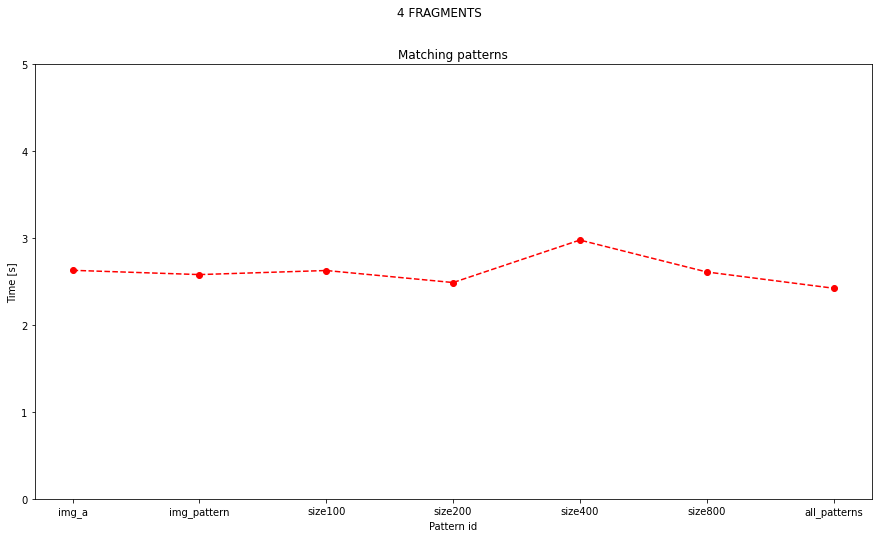

In [103]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
fig.suptitle("4 FRAGMENTS")
ax.plot(patterns_id, matching_times, "r--o")
ax.set_ylim([0, 5])
ax.set_title("Matching patterns")
ax.set_xlabel("Pattern id")
ax.set_ylabel("Time [s]")

### 8 fragments

In [104]:
all_patterns = [img_a, img_pattern, size100, size200, size400, size800]
patterns = [[img_a], [img_pattern], [size100], [size200], [size400], [size800], all_patterns]
res = time_test(img_8, patterns)
building_times = res[0]
matching_times = res[1]

Pattern size : [(10, 9)]
Automata building time : 0.001001596450805664
Pattern matching time : 0.2961294651031494

Pattern size : [(17, 99)]
Automata building time : 0.009968996047973633
Pattern matching time : 0.2950422763824463

Pattern size : [(100, 100)]
Automata building time : 0.04203343391418457
Pattern matching time : 0.3100755214691162

Pattern size : [(200, 200)]
Automata building time : 0.1770038604736328
Pattern matching time : 0.30299806594848633

Pattern size : [(400, 400)]
Automata building time : 1.503422737121582
Pattern matching time : 0.31799983978271484

Pattern size : [(800, 800)]
Automata building time : 4.399275064468384
Pattern matching time : 0.2610504627227783

Pattern size : [(10, 9), (17, 99), (100, 100), (200, 200), (400, 400), (800, 800)]
Automata building time : 6.125144958496094
Pattern matching time : 0.26799964904785156

Pattern size : [(10, 9)]
Automata building time : 0.001013040542602539
Pattern matching time : 0.29218268394470215

Pattern size : [(

Text(0, 0.5, 'Time [s]')

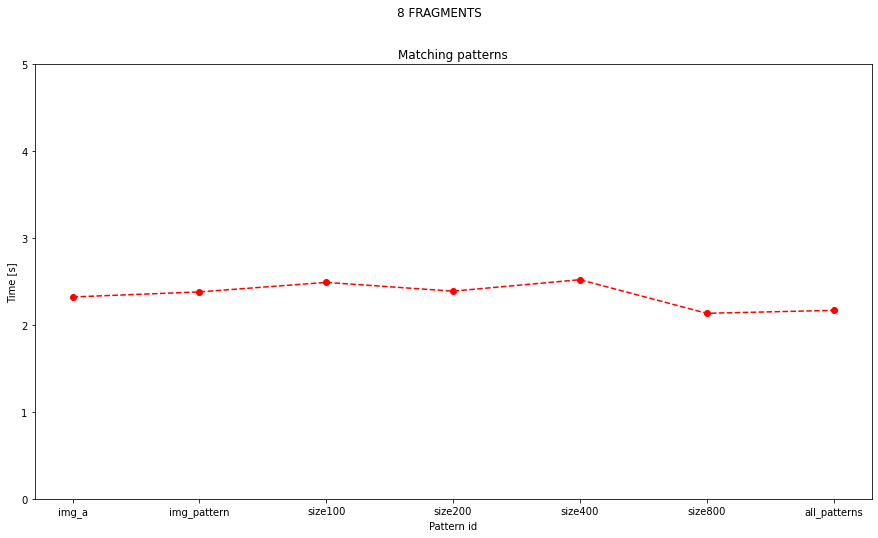

In [105]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
fig.suptitle("8 FRAGMENTS")
ax.plot(patterns_id, matching_times, "r--o")
ax.set_ylim([0, 5])
ax.set_title("Matching patterns")
ax.set_xlabel("Pattern id")
ax.set_ylabel("Time [s]")

In [ ]:
Czasy przeszukiwania wyszły sumarycznie takie same, brakuje wyjścia z funkcji jeśli rozmiar wzorca przekracza rozmiar 
przeszukiwanego pliku więc dlatego czasy się zgadzają dla 4 i 8 fragmentów mimo to że wzorzec "size800" przekracza ich rozmiar.
Ale też istnieje duża szansa że wzorzec znajdować się będzie we fragmencie pliku gdzie zachodzi rozfragmentowanie, więc
lepiej nie dzielić na fragmenty albo na przynajmniej takie aby wzorzec mógł się w nich znaleść 2mx2n.